In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import numpy as np
import xgboost as xgb
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import seaborn as sns
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy
import sqlite3
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sqlalchemy import create_engine # database connection
import datetime as dt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from collections import Counter
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [4]:
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [5]:
dfnlp.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667


In [6]:
dfppro.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [7]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [8]:
df_merged = df1.merge(df2, how='left', on='id')

In [9]:
df_merged.head(2)

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [10]:
#Merging question 1 and 2 to merged to dataframe
df_merged["question1"] = df["question1"]
df_merged["question2"] = df["question2"]

In [11]:
df_merged.head(1)

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,question1,question2
0,0,0,0.99998,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,57,14,12,10.0,23.0,0.434783,2,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...


In [12]:
finalp = df_merged[df_merged.is_duplicate == 1].sample(50000,random_state =2)
finaln = df_merged[df_merged.is_duplicate == 0].sample(50000,random_state =2)
df_sample = pd.concat([finalp,finaln],ignore_index=True)
y = df_sample.is_duplicate.values
df_sample.drop(['id', 'is_duplicate'], axis=1, inplace=True)

In [13]:
#splitting the data into train and test
Xtrain,Xtest,ytrain,ytest = train_test_split(df_sample,y, test_size=0.3)

In [14]:
#TFIDF
tfidf    = TfidfVectorizer(ngram_range=(1,2),min_df=10)
q1_train =  tfidf.fit_transform(Xtrain["question1"])
q1_test  =  tfidf.transform(Xtest["question1"])
q2_train =  tfidf.fit_transform(Xtrain["question2"])
q2_test  =  tfidf.transform(Xtest["question2"])

In [15]:
#dropping question 1 and 2 since we dont need them anymore
Xtrain.drop(['question1', 'question2'], axis=1, inplace=True)
Xtest.drop(['question1', 'question2'], axis=1, inplace=True)
#merging tfidf and other features using hstack
X_train = hstack([q1_train,q2_train,Xtrain])
X_test  = hstack([q1_test,q2_test,Xtest])


In [16]:
X_train.shape

(70000, 24200)

In [17]:
X_test.shape

(30000, 24200)

<h2> Building a random model (Finding worst-case log-loss)</h2>

In [18]:
test_len = len(ytest)

In [19]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8854420811557809


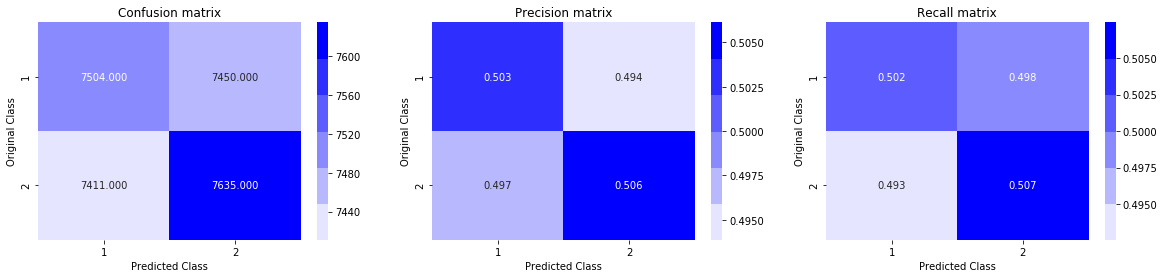

In [20]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(ytest, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(ytest, predicted_y)

<h2> Logistic Regression with hyperparameter tuning <h2>

For values of alpha =  1e-05 The log loss is: 0.4670662900390865
For values of alpha =  0.0001 The log loss is: 0.4709587455859122
For values of alpha =  0.001 The log loss is: 0.4741236052051627
For values of alpha =  0.01 The log loss is: 0.4688011579063153
For values of alpha =  0.1 The log loss is: 0.47436450518393664
For values of alpha =  1 The log loss is: 0.5037411454441058
For values of alpha =  10 The log loss is: 0.5569088304617135


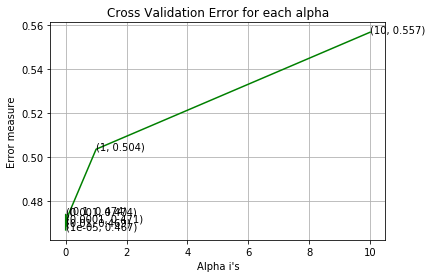

For values of best alpha =  1e-05 The train log loss is: 0.46951161901268995
For values of best alpha =  1e-05 The test log loss is: 0.4670662900390865
Total number of data points : 30000


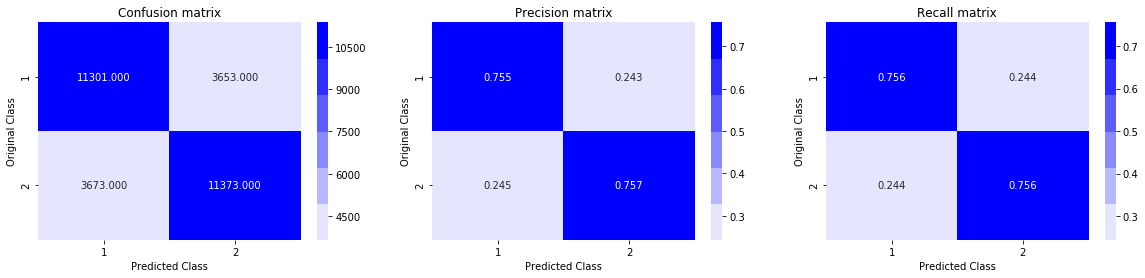

In [21]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, ytrain)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, ytrain)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(ytest, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(ytest, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, ytrain)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, ytrain)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(ytrain, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(ytest, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(ytest, predicted_y)

<h2> Linear SVM with hyperparameter tuning <h2>

For values of alpha =  1e-05 The log loss is: 0.4917750248190537
For values of alpha =  0.0001 The log loss is: 0.5175820049192646
For values of alpha =  0.001 The log loss is: 0.5297838313490428
For values of alpha =  0.01 The log loss is: 0.5254686753742887
For values of alpha =  0.1 The log loss is: 0.5079456988439974
For values of alpha =  1 The log loss is: 0.5699700264432982
For values of alpha =  10 The log loss is: 0.6832199481326707


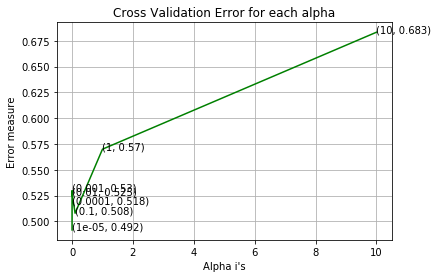

For values of best alpha =  1e-05 The train log loss is: 0.4941983790371719
For values of best alpha =  1e-05 The test log loss is: 0.4917750248190537
Total number of data points : 30000


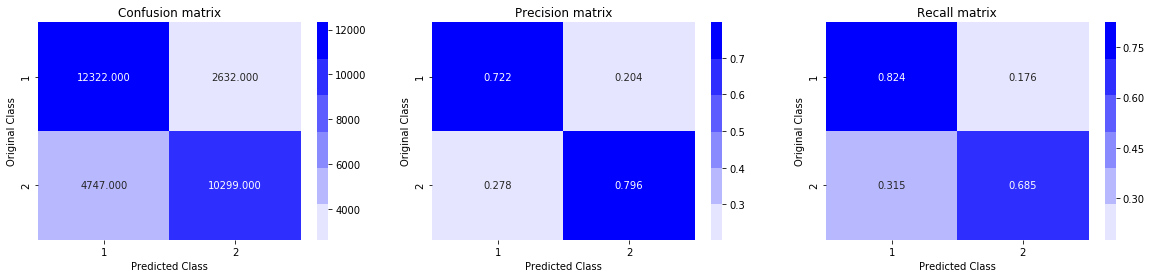

In [22]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, ytrain)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, ytrain)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(ytest, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(ytest, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, ytrain)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, ytrain)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(ytrain, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(ytest, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(ytest, predicted_y)

<h2>XGBoost with Hyper Parameter tuning <h2>

In [29]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
fit_params = {"eval_set":[(X_test, ytest)], 
                "eval_metric": 'logloss',
                "early_stopping_rounds":15,
                "verbose":10}
param_dist = {'n_estimators': [150,300,500,700,1000],
              'learning_rate': [0.02,0.05,0.08,0.09,0.1,0.15,0.2,0.25,0.3],
              'subsample': [0.4,0.5,0.6,0.7,0.8,0.9],
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': [0.4,0.5,0.6,0.7,0.8,0.9],
             }
clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 15, scoring = 'neg_log_loss',error_score=0, n_jobs = -1,fit_params=fit_params)
clf.fit(X_train,ytrain)

[0]	validation_0-logloss:0.6722
Will train until validation_0-logloss hasn't improved in 15 rounds.
[10]	validation_0-logloss:0.530102
[20]	validation_0-logloss:0.459629
[30]	validation_0-logloss:0.41862
[40]	validation_0-logloss:0.395055
[50]	validation_0-logloss:0.379055
[60]	validation_0-logloss:0.368885
[70]	validation_0-logloss:0.362087
[80]	validation_0-logloss:0.356872
[90]	validation_0-logloss:0.353755
[100]	validation_0-logloss:0.350741
[110]	validation_0-logloss:0.348897
[120]	validation_0-logloss:0.347102
[130]	validation_0-logloss:0.346218
[140]	validation_0-logloss:0.344949
[150]	validation_0-logloss:0.344113
[160]	validation_0-logloss:0.342916
[170]	validation_0-logloss:0.342092
[180]	validation_0-logloss:0.341418
[190]	validation_0-logloss:0.340942
[200]	validation_0-logloss:0.340228
[210]	validation_0-logloss:0.33991
[220]	validation_0-logloss:0.33947
[230]	validation_0-logloss:0.339078
[240]	validation_0-logloss:0.33851
[250]	validation_0-logloss:0.338289
[260]	validat

RandomizedSearchCV(cv=None, error_score=0,
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params={'eval_set': [(<30000x24200 sparse matrix of type '<class 'numpy.float64'>'
	with 1525236 stored elements in COOrdinate format>, array([0, 0, ..., 1, 1], dtype=int64))], 'eval_metric': 'logloss', 'early_stopping_rounds': 15, 'verbose': 10},
          iid=True, n_iter=15, n_jobs=-1,
          param_distributions={'n_estimators': [150, 300, 500, 700, 1000], 'learning_rate': [0.02, 0.05, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3], 'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'colsample_bytree'

In [30]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [31]:
#store the optimal paramters
params = clf.best_params_
print(params)

{'subsample': 0.9, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.5}


In [32]:
#train model with optimal parameters
model = xgb.XGBClassifier( objective ='binary:logistic',learning_rate=params["learning_rate"],subsample = params["subsample"],max_depth=params["max_depth"],colsample_bytree = params["colsample_bytree"],n_estimators=params["n_estimators"], n_jobs=-1)
model.fit(X_train, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)

In [33]:
predict_y = model.predict_proba(X_test)
print("The test log loss is:",log_loss(ytest, predict_y, labels=model.classes_, eps=1e-15))

The test log loss is: 0.32622809174884154


Total number of data points : 30000


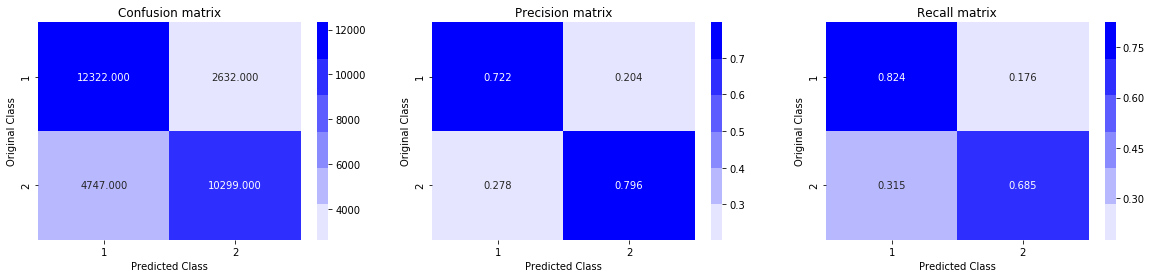

In [34]:
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(ytest, predicted_y)

Conclusions:

In [35]:
from prettytable import PrettyTable
x= PrettyTable()
x.field_names = ["Model","Logloss "]
x.add_row(["Random Model", 0.885])
x.add_row(["Logistic Regression", 0.467])
x.add_row(["Linear SVM", 0.497])
x.add_row(["XGBoost", 0.326])
print(x)

+---------------------+----------+
|        Model        | Logloss  |
+---------------------+----------+
|     Random Model    |  0.885   |
| Logistic Regression |  0.467   |
|      Linear SVM     |  0.497   |
|       XGBoost       |  0.326   |
+---------------------+----------+


As we can see, from the log loss as well as the confusion matrix, XGBoost works better in this Quora question pair problem with a logloss of 0.326.